In [1]:
import pandas as pd
import numpy as np

## Treemap images loading (X)

Images are cropped on their borders because of white edges. Then, they are resized in order to not take more memory than necessary.

In [2]:
%%time

# DL with Python - François Chollet (pp. 162-163)
from PIL import Image
from keras.preprocessing import image
import glob

path = '../data/COMMON_GENES_CHR_TREEMAPS/'
filelist = glob.glob(path + '*.png')

brca_images = dict()
non_brca_images = dict()
w, h = (image.load_img(filelist[1]).size)

basewidth = 100
wpercent = (basewidth/float(w))
hsize = int((float(h)*float(wpercent)))

i = 0 
for filename in filelist:
    sample = filename.split(" ")[1]
    if(True):
        if('NON' in sample):
            non_brca_images[sample.split("_")[0].replace('.','-')] = image.load_img(filename).crop((11, 11, w-13, h-13)).resize((basewidth,hsize), Image.ANTIALIAS)
        else:
            brca_images[sample.split("_")[0].replace('.','-')] = image.load_img(filename).crop((11, 11, w-13, h-13)).resize((basewidth,hsize), Image.ANTIALIAS)

Using TensorFlow backend.


CPU times: user 24.7 s, sys: 216 ms, total: 25 s
Wall time: 25 s


In [3]:
print('There are {} brca images and {} non-brca images'.format(len(brca_images), len(non_brca_images)))

There are 1212 brca images and 9323 non-brca images


## Visualizing some images

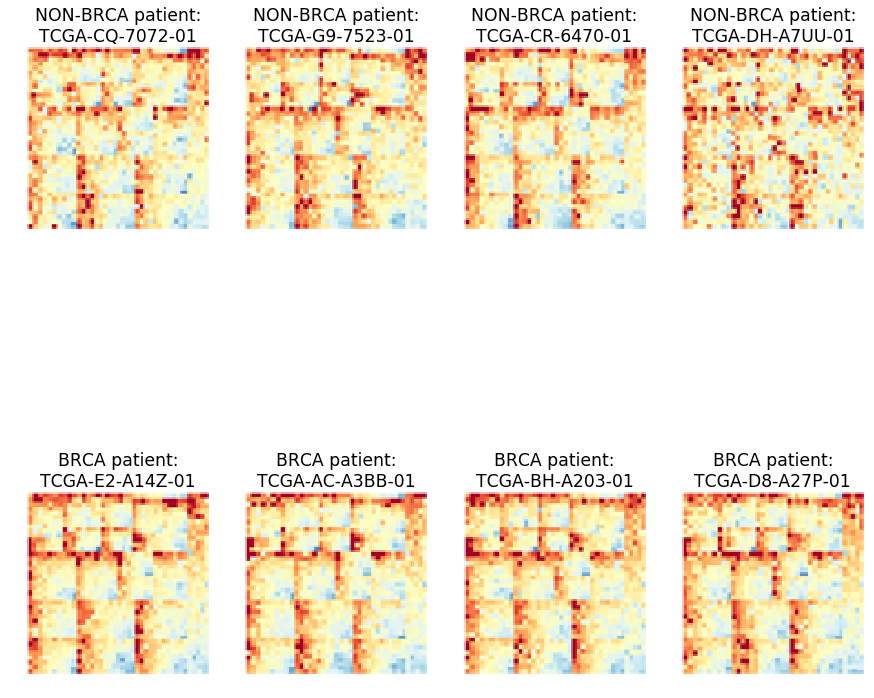

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.subplots(4,4,figsize=(15,15))
# plot
for i in range(0,4):
    key_img = list(non_brca_images.keys())[np.random.randint(len(non_brca_images),size= 1)[0]]
    image = non_brca_images[key_img]
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.title('NON-BRCA patient:\n' + key_img, fontsize='xx-large')
    plt.imshow(image)

for i in range(4,8):
    key_img = list(brca_images.keys())[np.random.randint(len(brca_images),size= 1)[0]]
    image = brca_images[key_img]
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.title('BRCA patient:\n' + key_img, fontsize='xx-large')
    plt.imshow(image)
    


## Survival data loading (Y)

In [5]:
brca_clinical = pd.read_hdf('../data/TCGA_data.h5', key='brca_clinical')
non_brca_clinical = pd.read_hdf('../data/TCGA_data.h5', key='non_brca_clinical')

In [6]:
len(brca_clinical)+len(non_brca_clinical)

10497

In [7]:
len(brca_images)+len(non_brca_images)

10535

In [8]:
# Deleting samples with 'NaN's in OS-columns 

## non_brca
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical['OS'] = non_brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].astype(float)
non_brca_clinical['OS'] = non_brca_clinical['OS'].astype(float)

## brca
brca_clinical['OS.time'] = brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical['OS'] = brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
brca_clinical['OS.time'] = brca_clinical['OS.time'].astype(float)
brca_clinical['OS'] = brca_clinical['OS'].astype(float)

In [9]:
print('There are {} brca clinical info and {} non-brca clinical info'.format(len(brca_clinical), len(non_brca_clinical)))

There are 1196 brca clinical info and 9224 non-brca clinical info


## Creating X and Y numpy-arrays

Note that there are differences between patients with survival info and with images; only patients in both datasets are mantained

In [10]:
common_pat_brca = set(brca_images.keys()).intersection(brca_clinical.index)

In [11]:
len(common_pat_brca)

1196

#### Deleting images and OS data from not common patients

In [12]:
# Mantaining brca patients with both X and Y available data
brca_clinical = brca_clinical.loc[common_pat_brca]

for k in set(list(brca_images.keys())).difference(common_pat_brca):
    del brca_images[k]

In [13]:
len(brca_images)

1196

In [14]:
len(brca_clinical)

1196

In [15]:
len(common_pat_brca)

1196

In [16]:
common_pat_non_brca = set(non_brca_images.keys()).intersection(non_brca_clinical.index)

In [17]:
# Mantaining brca patients with both X and Y available data
non_brca_clinical = non_brca_clinical.loc[common_pat_non_brca]

for k in set(list(non_brca_images.keys())).difference(common_pat_non_brca):
    del non_brca_images[k]

In [18]:
len(non_brca_images)

9224

In [19]:
len(non_brca_clinical)

9224

#### From OS to Survival

In [20]:
# Create 39 equally spaced intervals for follow-up time, from 0 to 5 years:
breaks = np.arange(0.,365.*5,365./8)
n_intervals = len(breaks)-1
timegap = breaks[1:] - breaks[:-1]

In [21]:
n_intervals

39

In [22]:
max(breaks)/365

4.875

In [23]:
import nnet_survival
non_brca_y = nnet_survival.make_surv_array(non_brca_clinical['OS.time'],
                             non_brca_clinical['OS'],
                             breaks)
brca_y = nnet_survival.make_surv_array(brca_clinical['OS.time'],
                             brca_clinical['OS'],
                             breaks)

In [24]:
non_brca_y.shape

(9224, 78)

#### From PIL.Images to Numpy

In [25]:
%%time

import numpy as np
from keras.preprocessing import image

samples = list(non_brca_clinical.index)

X_non_brca = np.empty((len(samples), 100, 100, 3))

for i in range(0, len(samples)):
    
    X_non_brca[i] = image.img_to_array(non_brca_images[samples[i]])

CPU times: user 392 ms, sys: 376 ms, total: 768 ms
Wall time: 768 ms


In [26]:
%%time

import numpy as np
from keras.preprocessing import image

samples = list(brca_clinical.index)

X_brca = np.empty((len(samples), 100, 100, 3))

for i in range(0, len(samples)):
    X_brca[i] = image.img_to_array(brca_images[samples[i]])

CPU times: user 61.2 ms, sys: 40.1 ms, total: 101 ms
Wall time: 100 ms


In [27]:
print("BRCA data shapes: \n X: {} \t Y: {}".format(X_brca.shape, brca_y.shape))

BRCA data shapes: 
 X: (1196, 100, 100, 3) 	 Y: (1196, 78)


In [28]:
print("Non-BRCA data shapes: \n X: {} \t Y: {}".format(X_non_brca.shape, non_brca_y.shape))

Non-BRCA data shapes: 
 X: (9224, 100, 100, 3) 	 Y: (9224, 78)


In [29]:
# to save memory
del non_brca_images
del brca_images

# TRAINING MODELS

In [30]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Activation, Dropout, Flatten
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import warnings
from keras.regularizers import l1
from keras.optimizers import Adam
import tensorflow as tf

In [31]:
# Using C-index as evaluation metric (using a custom callback)

from lifelines.utils import concordance_index
from keras.callbacks import Callback

class CIndex(Callback):
    """
    Callback that computes the C-index metric both on training and test data after each epoch.
    
    Arguments:
        train_x: Numpy array containing the training dataset.
        train_time: Numpy array with survival time for training dataset.
        train_event: Numpy array with survival event for training dataset.
        val_x: Numpy array containing the test dataset.
        val_time: Numpy array with survival time for test dataset.
        val_event: Numpy array with survival event for test dataset.
        filepath: path to save the model.
        years: number of years to compute c-index
        patience: patience for early-stop training
    """
    
    def __init__(self, train_x, train_time, train_event, val_x, val_time, val_event, filepath, years=2, patience=5):
        super(Callback, self).__init__()
        self.X_tr = train_x
        self.time_tr = train_time
        self.event_tr = train_event
        self.X_val = val_x
        self.time_val = val_time
        self.event_val = val_event
        self.years = years
        self.patience = patience
        self.best = 0.0
        self.wait = 0  #counter for patience
        self.best_rounds = 1
        self.counter = 0
        self.filepath = filepath
        
    def on_train_begin(self, logs={}):
        self.c_index_dict = {'c-index': [], 'val_c-index': []}

    def on_epoch_end(self, epoch, logs={}):
        self.counter +=1

        y_tr=self.model.predict_proba(self.X_tr,verbose=0)
        yr_surv=np.cumprod(y_tr[:,0:np.nonzero(breaks>365*self.years)[0][0]], axis=1)[:,-1]
        c_index_tr = concordance_index(self.time_tr, yr_surv, self.event_tr)
        y_val=self.model.predict_proba(self.X_val,verbose=0)
        yr_surv_val=np.cumprod(y_val[:,0:np.nonzero(breaks>365*self.years)[0][0]], axis=1)[:,-1]
        c_index_val = concordance_index(self.time_val, yr_surv_val, self.event_val)

        print('\tc-index: %s - val_c-index: %s' % (str(round(c_index_tr, 4)), str(round(c_index_val, 4))))
        
        if (c_index_val > self.best):
            self.c_index_dict['c-index'].append(c_index_tr)
            self.c_index_dict['val_c-index'].append(c_index_val)

            self.best = c_index_val
            self.best_rounds = self.counter
            self.wait = 0
            self.model.save_weights(self.filepath, overwrite=True)
        else:
            if self.wait >= self.patience: #no more patience, retrieve best model
                self.model.stop_training = True
                print('Best number of rounds: %d \nValidation C-Index: %f \n' % (self.best_rounds, self.best))
                self.model.load_weights(self.filepath)
            self.wait += 1

## NON-BRCA

In [ ]:
%%time
# Split dataset into train and test
from sklearn.model_selection import train_test_split

X_non_brca_train, X_non_brca_test, y_non_brca_train, y_non_brca_test, train_index, test_index = train_test_split(X_non_brca, non_brca_y, np.arange(len(X_non_brca)), test_size=0.2, random_state=42)
X_non_brca_train, X_non_brca_val, y_non_brca_train, y_non_brca_val, train_index, val_index = train_test_split(X_non_brca_train, y_non_brca_train, train_index, test_size=0.2, random_state=44)

### Bayesian Optimization (non-brca)

In [ ]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
space = {
    'conv_choice': hp.choice('conv_num_layers', 
                            [{'layers': 'two',
                             'units_2conv2': hp.choice('units_2conv2', [16, 32, 64, 128]),
                              '2kernel2': hp.choice('2kernel2', [3,5]),
                              '2pool2': 2,
                             'dropout_2conv2': hp.choice('dropout_2conv2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3conv2': hp.choice('units_3conv2', [16, 32, 64, 128]),
                             '3kernel2': hp.choice('3kernel2', [3,5]),
                             '3pool2': 2,
                             'dropout_3conv2': hp.choice('dropout_3conv2', [0.25, 0.5, 0.75]),
                             'units_3conv3': hp.choice('units_3conv3', [16, 32, 64, 128]),
                             '3kernel3': hp.choice('kernel3', [3,5]),
                             '3pool3': 2,
                             'dropout_3conv3': hp.choice('dropout_3conv3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'dense_choice': hp.choice('dense_num_layers', 
                            [{'layers': 'two',
                             'units_2dense2': hp.choice('units_2dense2', [16, 32, 64, 128]),
                             'dropout_2dense2': hp.choice('dropout_2dense2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3dense2': hp.choice('units_3dense2', [16, 32, 64, 128]),
                             'dropout_3dense2': hp.choice('dropout_3dense2', [0.25, 0.5, 0.75]),
                             'units_3dense3': hp.choice('units_3dense3', [16, 32, 64, 128]),
                             'dropout_3dense3': hp.choice('dropout_3dense3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'units_conv1': hp.choice('units_conv1', [16, 32, 64, 128]),
    'kernel1': hp.choice('kernel1', [3,5]),
    'pool1': 2,
    'dropout_conv1': hp.choice('dropout_conv1', [0.25, 0.5, 0.75]),
    'units_dense1': hp.choice('units_dense1', [16, 32, 64, 128]),
    'dropout_dense1': hp.choice('dropout_dense1', [0.25, 0.5, 0.75]),
    'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
    'nb_epochs' : 100,
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'activation': 'relu'                                            
}

In [ ]:
def train_non_brca(params):
    print('Params testing: ', params)
    print('\n')

    # Prevent GPU memory allocation problems
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    K.set_session(tf.Session(config=config))

    ## CREATE MODEL
    model = Sequential()

    # Conv layer 1 ---
    model.add(Conv2D(filters=params['units_conv1'], 
                     kernel_size=(params['kernel1'], params['kernel1']),
                     input_shape = (X_non_brca_train.shape[1],
                                    X_non_brca_train.shape[2],
                                    X_non_brca_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['pool1'],params['pool1'])))
    model.add(Dropout(params['dropout_conv1']))

    if params['conv_choice']['layers'] == 'two':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_2conv2'], 
                     kernel_size=(params['conv_choice']['2kernel2'], params['conv_choice']['2kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['2pool2'], params['conv_choice']['2pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_2conv2']))
    elif params['conv_choice']['layers'] == 'three':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv2'], 
                     kernel_size=(params['conv_choice']['3kernel2'], params['conv_choice']['3kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool2'], params['conv_choice']['3pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv2']))
        # Conv layer 3 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv3'], 
                     kernel_size=(params['conv_choice']['3kernel3'], params['conv_choice']['3kernel3'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool3'], params['conv_choice']['3pool3'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv3']))

    # Flatten layer ---
    model.add(Flatten())
    
    # Dense layer 1 ---
    model.add(Dense(params['units_dense1']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout_dense1']))

    if params['dense_choice']['layers']== 'two':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_2dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_2dense2']))
    elif params['dense_choice']['layers']== 'three':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_3dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense2']))
        # Dense layer 3 ---
        model.add(Dense(params['dense_choice']['units_3dense3']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense3']))
        
    # Output layer ---
    model.add(Dense(n_intervals, activation='sigmoid'))

    optimizer = Adam(lr=params['lr'])

    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)
    
    #model.summary()
    
    batch = params['batch_size']
    n_epoch = params['nb_epochs']
    hist_c_index = CIndex(X_non_brca_train,
                    non_brca_clinical.iloc[train_index]['OS.time'],
                    non_brca_clinical.iloc[train_index]['OS'],
                    X_non_brca_val,
                    non_brca_clinical.iloc[val_index]['OS.time'],
                    non_brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/common_best_non-brca.h5')

    callbacks = [hist_c_index]    
    
    ## Fit model using training data
    start = timer()
    model.fit(X_non_brca_train, 
              y_non_brca_train, 
              batch_size=batch, 
              epochs=n_epoch, 
              validation_data = [X_non_brca_val, y_non_brca_val],
              callbacks=callbacks,
              verbose = 0)
    run_time = timer() - start
    
    predictions = model.predict_proba(X_non_brca_test,verbose=0)
    twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
    score = concordance_index(non_brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, non_brca_clinical.iloc[test_index]['OS'])

    # Return loss
    return {'loss': score*(-1),
            'params': params,
            'train_time': run_time,
            'status': STATUS_OK, 
            'rounds':hist_c_index.best_rounds}

In [ ]:
from timeit import default_timer as timer
from multiprocessing import Pool
from hyperopt import STATUS_OK

def objective_non_brca(params):
    from sklearn.metrics import roc_auc_score
    
    from keras.models import Sequential
    from keras.layers import Input, Dense, Conv1D, MaxPool1D, Activation, Dropout, Flatten
    from keras import regularizers, optimizers
    from keras.layers.normalization import BatchNormalization
    from keras.callbacks import EarlyStopping

    from keras.regularizers import l1
    from keras.optimizers import Adam
   
    with Pool(1) as p:
            trial = p.apply(train_non_brca, args=(params, ))

    return trial

In [ ]:
import pickle

with open("keras-models/common_hyper_opt_chromosome_non-brca.pkl", 'rb') as f:
    [trials_non_brca, best_non_brca] = pickle.load(f)

In [ ]:
trials_non_brca

## BRCA

In [32]:
%%time
# Split dataset into train and test
from sklearn.model_selection import train_test_split

X_brca_train, X_brca_test, y_brca_train, y_brca_test, train_index, test_index = train_test_split(X_brca, brca_y, np.arange(len(X_brca)), test_size=0.2, random_state=42)
X_brca_train, X_brca_val, y_brca_train, y_brca_val, train_index, val_index = train_test_split(X_brca_train, y_brca_train, train_index, test_size=0.2, random_state=44)

CPU times: user 101 ms, sys: 72.1 ms, total: 173 ms
Wall time: 172 ms


### Bayesian Optimization (brca)

In [ ]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
space = {
    'conv_choice': hp.choice('conv_num_layers', 
                            [{'layers': 'two',
                             'units_2conv2': hp.choice('units_2conv2', [16, 32, 64, 128]),
                              '2kernel2': hp.choice('2kernel2', [3,5]),
                              '2pool2': 2,
                             'dropout_2conv2': hp.choice('dropout_2conv2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3conv2': hp.choice('units_3conv2', [16, 32, 64, 128]),
                             '3kernel2': hp.choice('3kernel2', [3,5]),
                             '3pool2': 2,
                             'dropout_3conv2': hp.choice('dropout_3conv2', [0.25, 0.5, 0.75]),
                             'units_3conv3': hp.choice('units_3conv3', [16, 32, 64, 128]),
                             '3kernel3': hp.choice('kernel3', [3,5]),
                             '3pool3': 2,
                             'dropout_3conv3': hp.choice('dropout_3conv3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'dense_choice': hp.choice('dense_num_layers', 
                            [{'layers': 'two',
                             'units_2dense2': hp.choice('units_2dense2', [16, 32, 64, 128]),
                             'dropout_2dense2': hp.choice('dropout_2dense2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3dense2': hp.choice('units_3dense2', [16, 32, 64, 128]),
                             'dropout_3dense2': hp.choice('dropout_3dense2', [0.25, 0.5, 0.75]),
                             'units_3dense3': hp.choice('units_3dense3', [16, 32, 64, 128]),
                             'dropout_3dense3': hp.choice('dropout_3dense3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'units_conv1': hp.choice('units_conv1', [16, 32, 64, 128]),
    'kernel1': hp.choice('kernel1', [3,5]),
    'pool1': 2,
    'dropout_conv1': hp.choice('dropout_conv1', [0.25, 0.5, 0.75]),
    'units_dense1': hp.choice('units_dense1', [16, 32, 64, 128]),
    'dropout_dense1': hp.choice('dropout_dense1', [0.25, 0.5, 0.75]),
    'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
    'nb_epochs' : 100,
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'activation': 'relu'                                            
}

In [ ]:
def train_brca(params):
    print('Params testing: ', params)
    print('\n')

    # Prevent GPU memory allocation problems
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    K.set_session(tf.Session(config=config))

    ## CREATE MODEL
    model = Sequential()

    # Conv layer 1 ---
    model.add(Conv2D(filters=params['units_conv1'], 
                     kernel_size=(params['kernel1'], params['kernel1']),
                     input_shape = (X_brca_train.shape[1],
                                    X_brca_train.shape[2],
                                    X_brca_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['pool1'],params['pool1'])))
    model.add(Dropout(params['dropout_conv1']))

    if params['conv_choice']['layers'] == 'two':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_2conv2'], 
                     kernel_size=(params['conv_choice']['2kernel2'], params['conv_choice']['2kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['2pool2'], params['conv_choice']['2pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_2conv2']))
    elif params['conv_choice']['layers'] == 'three':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv2'], 
                     kernel_size=(params['conv_choice']['3kernel2'], params['conv_choice']['3kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool2'], params['conv_choice']['3pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv2']))
        # Conv layer 3 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv3'], 
                     kernel_size=(params['conv_choice']['3kernel3'], params['conv_choice']['3kernel3'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool3'], params['conv_choice']['3pool3'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv3']))

    # Flatten layer ---
    model.add(Flatten())
    
    # Dense layer 1 ---
    model.add(Dense(params['units_dense1']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout_dense1']))

    if params['dense_choice']['layers']== 'two':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_2dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_2dense2']))
    elif params['dense_choice']['layers']== 'three':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_3dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense2']))
        # Dense layer 3 ---
        model.add(Dense(params['dense_choice']['units_3dense3']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense3']))
        
    # Output layer ---
    model.add(Dense(n_intervals, activation='sigmoid'))

    optimizer = Adam(lr=params['lr'])

    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)
    
    model.summary()
    
    batch = params['batch_size']
    n_epoch = params['nb_epochs']

    hist_c_index = CIndex(X_brca_train,
                    brca_clinical.iloc[train_index]['OS.time'],
                    brca_clinical.iloc[train_index]['OS'],
                    X_brca_val,
                    brca_clinical.iloc[val_index]['OS.time'],
                    brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/common_best_brca.h5')

    callbacks = [hist_c_index]    
    
    ## Fit model using training data
    start = timer()
    model.fit(X_brca_train, 
              y_brca_train, 
              batch_size=batch, 
              epochs=n_epoch, 
              validation_data = [X_brca_val, y_brca_val],
              callbacks=callbacks,
              verbose = 0)
    run_time = timer() - start
    
    predictions = model.predict_proba(X_brca_test,verbose=0)
    twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
    score = concordance_index(brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, brca_clinical.iloc[test_index]['OS'])

    # Return loss
    return {'loss': score*(-1),
            'params': params,
            'train_time': run_time,
            'status': STATUS_OK, 
            'rounds':hist_c_index.best_rounds}

In [ ]:
breaks>365*5

In [ ]:
from timeit import default_timer as timer
from multiprocessing import Pool
from hyperopt import STATUS_OK

def objective_brca(params):
    from sklearn.metrics import roc_auc_score
    
    from keras.models import Sequential
    from keras.layers import Input, Dense, Conv1D, MaxPool1D, Activation, Dropout, Flatten
    from keras import regularizers, optimizers
    from keras.layers.normalization import BatchNormalization
    from keras.callbacks import EarlyStopping

    from keras.regularizers import l1
    from keras.optimizers import Adam
   
    with Pool(1) as p:
            trial = p.apply(train_brca, args=(params, ))

    return trial

In [ ]:
import pickle

with open("keras-models/common_hyper_opt_chromosome.pkl", 'rb') as f:
    [trials_brca, best_brca] = pickle.load(f)

In [ ]:
trials_brca.best_trial


## BRCA (fine tuning) 

### Train non-brca model with all non-brca data

In [ ]:
print("Input data shape: {}".format(X_non_brca.shape))

In [ ]:
print("Output data shape: {}".format(non_brca_y.shape))

In [ ]:
import pickle

with open("keras-models/common_hyper_opt_chromosome_non-brca.pkl", 'rb') as f:
    [trials_non_brca, best_non_brca] = pickle.load(f)

In [ ]:
params = trials_non_brca.best_trial['result']['params']

In [ ]:
trials_non_brca.best_trial

In [ ]:
params

In [ ]:
# Prevent GPU memory allocation problems
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
K.set_session(tf.Session(config=config))

## CREATE MODEL
model = Sequential()

# Conv layer 1 ---
model.add(Conv2D(filters=params['units_conv1'], 
                 kernel_size=(params['kernel1'], params['kernel1']),
                 input_shape = (X_non_brca.shape[1],
                                X_non_brca.shape[2],
                                X_non_brca.shape[3])))
model.add(BatchNormalization())
model.add(Activation(params['activation']))
model.add(MaxPool2D(pool_size=(params['pool1'],params['pool1'])))
model.add(Dropout(params['dropout_conv1']))

if params['conv_choice']['layers'] == 'two':
    # Conv layer 2 ---
    model.add(Conv2D(filters=params['conv_choice']['units_2conv2'], 
                 kernel_size=(params['conv_choice']['2kernel2'], params['conv_choice']['2kernel2'])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['conv_choice']['2pool2'], params['conv_choice']['2pool2'])))
    model.add(Dropout(params['conv_choice']['dropout_2conv2']))
elif params['conv_choice']['layers'] == 'three':
    # Conv layer 2 ---
    model.add(Conv2D(filters=params['conv_choice']['units_3conv2'], 
                 kernel_size=(params['conv_choice']['3kernel2'], params['conv_choice']['3kernel2'])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool2'], params['conv_choice']['3pool2'])))
    model.add(Dropout(params['conv_choice']['dropout_3conv2']))
    # Conv layer 3 ---
    model.add(Conv2D(filters=params['conv_choice']['units_3conv3'], 
                 kernel_size=(params['conv_choice']['3kernel3'], params['conv_choice']['3kernel3'])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool3'], params['conv_choice']['3pool3'])))
    model.add(Dropout(params['conv_choice']['dropout_3conv3']))

# Flatten layer ---
model.add(Flatten())

# Dense layer 1 ---
model.add(Dense(params['units_dense1']))
model.add(BatchNormalization())
model.add(Activation(params['activation']))
model.add(Dropout(params['dropout_dense1']))

if params['dense_choice']['layers']== 'two':
    # Dense layer 2 ---
    model.add(Dense(params['dense_choice']['units_2dense2']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dense_choice']['dropout_2dense2']))
elif params['dense_choice']['layers']== 'three':
    # Dense layer 2 ---
    model.add(Dense(params['dense_choice']['units_3dense2']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dense_choice']['dropout_3dense2']))
    # Dense layer 3 ---
    model.add(Dense(params['dense_choice']['units_3dense3']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dense_choice']['dropout_3dense3']))

# Output layer ---
model.add(Dense(n_intervals, activation='sigmoid'))

optimizer = Adam(lr=params['lr'])

model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)

batch = params['batch_size']
n_epoch = params['nb_epochs'] 

## Fit model using all data
model.fit(X_non_brca, 
          non_brca_y, 
          batch_size=batch, 
          epochs=n_epoch)

In [ ]:
predictions = model.predict_proba(X_non_brca,verbose=0)
twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
score = concordance_index(non_brca_clinical['OS.time'], twoyr_surv, non_brca_clinical['OS'])
print(score)

In [ ]:
predictions.shape

In [ ]:
model.save('keras-models/MODEL_nonBRCA_all_data.h5')

### Fine tuning with bayesian optimization

In [33]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

In [34]:
space_fine_tuning = {
    'choice': hp.choice('num_layers', 
                            [{'layers': 'one'},
                            {'layers': 'two',
                             'units_2dense1': hp.choice('units_2dense1', [16, 32, 64, 128, 256]),
                             'dropout_2dense1': hp.choice('dropout_2dense1', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3dense1': hp.choice('units_3dense1', [16, 32, 64, 128, 256]),
                             'dropout_3dense1': hp.choice('dropout_3dense1', [0.25, 0.5, 0.75]),
                             'units_3dense2': hp.choice('units_3dense2', [16, 32, 64, 128, 256]),
                             'dropout_3dense2': hp.choice('dropout_3dense2', [0.25, 0.5, 0.75])
                            }]
                            ),
    'units_output': n_intervals,
    'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
    'nb_epochs' : 100,
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'activation_hidden': 'relu',
    'activation_output': 'sigmoid'
}

In [35]:
import nnet_survival

In [36]:
def train_fine_tuning(params):
    print('Params testing: ', params)
    print('\n')

    # Prevent GPU memory allocation problems
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    K.set_session(tf.Session(config=config))

    from keras.models import load_model

    non_brca_model = load_model('keras-models/MODEL_nonBRCA_all_data.h5', custom_objects={'loss': nnet_survival.surv_likelihood(n_intervals)})

    import pickle

    with open("keras-models/common_hyper_opt_chromosome_non-brca.pkl", 'rb') as f:
        [trials_non_brca, best_non_brca] = pickle.load(f)

    if trials_non_brca.best_trial['result']['params']['dense_choice']['layers'] == 'two':
        pop_layers = 6
    elif trials_non_brca.best_trial['result']['params']['dense_choice']['layers'] == 'three':
        pop_layers = 9
    
    for i in range(pop_layers):
        non_brca_model.pop()    
    
    for layer in non_brca_model.layers:
         layer.trainable = False
    
    model = Sequential()
    
    model.add(non_brca_model)

    if params['choice']['layers']== 'two':
        # Dense layer 1 ---
        model.add(Dense(params['choice']['units_2dense1']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation_hidden']))
        model.add(Dropout(params['choice']['dropout_2dense1']))
    elif params['choice']['layers']== 'three':
        # Dense layer 1 ---
        model.add(Dense(params['choice']['units_3dense1']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation_hidden']))
        model.add(Dropout(params['choice']['dropout_3dense1']))
        # Dense layer 2 ---
        model.add(Dense(params['choice']['units_3dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation_hidden']))
        model.add(Dropout(params['choice']['dropout_3dense2']))
        
    # Output layer ---
    model.add(Dense(params['units_output'], activation=params['activation_output']))

    optimizer = Adam(lr=params['lr'])
    
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)
    
    #model.summary()
    
    batch = params['batch_size']
    n_epoch = params['nb_epochs']

    hist_c_index = CIndex(X_brca_train,
                    brca_clinical.iloc[train_index]['OS.time'],
                    brca_clinical.iloc[train_index]['OS'],
                    X_brca_val,
                    brca_clinical.iloc[val_index]['OS.time'],
                    brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/common_best_fine-tuning_sigmoid.h5')

    callbacks = [hist_c_index]    
    
    ## Fit model using training data
    start = timer()
    model.fit(X_brca_train, 
              y_brca_train, 
              batch_size=batch, 
              epochs=n_epoch, 
              validation_data = [X_brca_val, y_brca_val],
              callbacks=callbacks,
              verbose=0)
    run_time = timer() - start
    
    predictions = model.predict_proba(X_brca_test,verbose=0)
    twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
    score = concordance_index(brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, brca_clinical.iloc[test_index]['OS'])

    # Return loss
    return {'loss': score*(-1),
            'params': params,
            'train_time': run_time,
            'status': STATUS_OK, 
            'rounds':hist_c_index.best_rounds}

In [37]:
from timeit import default_timer as timer
from multiprocessing import Pool
from hyperopt import STATUS_OK

def objective_fine_tuning(params):
    from sklearn.metrics import roc_auc_score
    
    from keras.models import Sequential
    from keras.layers import Input, Dense, Conv2D, MaxPool2D, Activation, Dropout, Flatten
    from keras import regularizers, optimizers
    from keras.layers.normalization import BatchNormalization
    from keras.callbacks import EarlyStopping

    from keras.regularizers import l1
    from keras.optimizers import Adam
       
    with Pool(1) as p:
            trial = p.apply(train_fine_tuning, args=(params, ))

    return trial

In [38]:
trials_fine_tuning = Trials()

best_fine_tuning = fmin(fn=objective_fine_tuning, space=space_fine_tuning, algo=tpe.suggest, trials=trials_fine_tuning, max_evals=100)

print (best_fine_tuning)
print (trials_fine_tuning.best_trial)

Params testing:                                      
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 64, 'choice': {'dropout_3dense1': 0.5, 'dropout_3dense2': 0.5, 'layers': 'three', 'units_3dense1': 256, 'units_3dense2': 16}, 'lr': 0.0007113584183678025, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.4594 - val_c-index: 0.5587               
	c-index: 0.4729 - val_c-index: 0.5251               
	c-index: 0.4955 - val_c-index: 0.474                
	c-index: 0.5224 - val_c-index: 0.44                 
	c-index: 0.5443 - val_c-index: 0.4204               
	c-index: 0.5534 - val_c-index: 0.4013               
	c-index: 0.5582 - val_c-index: 0.4089               
Best number of rounds: 1                             
Validation C-Index: 0.558723 

Params testing:                                                              
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'layers': 'one'}, 'lr': 0.002409771830167473

	c-index: 0.4883 - val_c-index: 0.6009                                       
	c-index: 0.4877 - val_c-index: 0.6009                                       
	c-index: 0.4875 - val_c-index: 0.6009                                       
	c-index: 0.4867 - val_c-index: 0.5996                                       
	c-index: 0.486 - val_c-index: 0.6                                           
	c-index: 0.4852 - val_c-index: 0.6013                                       
	c-index: 0.4847 - val_c-index: 0.6004                                       
	c-index: 0.4844 - val_c-index: 0.6009                                       
	c-index: 0.4836 - val_c-index: 0.6009                                       
	c-index: 0.4831 - val_c-index: 0.6009                                       
	c-index: 0.4828 - val_c-index: 0.6004                                       
	c-index: 0.4825 - val_c-index: 0.5996                                       
Best number of rounds: 39                                       

	c-index: 0.4951 - val_c-index: 0.597                                        
	c-index: 0.4932 - val_c-index: 0.5987                                       
	c-index: 0.4912 - val_c-index: 0.5966                                       
	c-index: 0.4899 - val_c-index: 0.5991                                       
	c-index: 0.4881 - val_c-index: 0.6                                          
	c-index: 0.4868 - val_c-index: 0.6004                                       
	c-index: 0.4856 - val_c-index: 0.5996                                       
	c-index: 0.4842 - val_c-index: 0.6                                          
	c-index: 0.4837 - val_c-index: 0.6013                                       
	c-index: 0.4829 - val_c-index: 0.5996                                       
	c-index: 0.4825 - val_c-index: 0.5979                                       
	c-index: 0.4817 - val_c-index: 0.597                                        
	c-index: 0.4815 - val_c-index: 0.5966                          

	c-index: 0.4861 - val_c-index: 0.6009                                          
Best number of rounds: 18                                                       
Validation C-Index: 0.602979 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'dropout_2dense1': 0.25, 'layers': 'two', 'units_2dense1': 32}, 'lr': 0.0005403546808555502, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.4897 - val_c-index: 0.6196                                          
	c-index: 0.4792 - val_c-index: 0.6174                                          
	c-index: 0.4659 - val_c-index: 0.6183                                          
	c-index: 0.4534 - val_c-index: 0.6115                                          
	c-index: 0.4464 - val_c-index: 0.5932                                          
	c-index: 0.4378 - val_c-index: 0.5813                                          
	c-index: 0.4328 

	c-index: 0.5095 - val_c-index: 0.5681                                          
Best number of rounds: 4                                                        
Validation C-Index: 0.594043 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 16, 'choice': {'dropout_3dense1': 0.25, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 64}, 'lr': 0.00018141788327767302, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.5031 - val_c-index: 0.4426                                          
	c-index: 0.5094 - val_c-index: 0.4779                                          
	c-index: 0.5209 - val_c-index: 0.4753                                          
	c-index: 0.5285 - val_c-index: 0.4889                                          
	c-index: 0.5325 - val_c-index: 0.4791                                          
	c-index: 0.527 - val_c-index: 0.4668             

	c-index: 0.4971 - val_c-index: 0.4366                                          
	c-index: 0.4986 - val_c-index: 0.4668                                          
	c-index: 0.5094 - val_c-index: 0.4681                                          
	c-index: 0.5177 - val_c-index: 0.4843                                          
	c-index: 0.5213 - val_c-index: 0.4872                                          
	c-index: 0.5184 - val_c-index: 0.4774                                          
	c-index: 0.5223 - val_c-index: 0.4774                                          
	c-index: 0.5252 - val_c-index: 0.4804                                          
	c-index: 0.5275 - val_c-index: 0.4774                                          
	c-index: 0.5271 - val_c-index: 0.4689                                          
	c-index: 0.5245 - val_c-index: 0.4651                                          
Best number of rounds: 5                                                        
Validation C-Index: 0.487234

	c-index: 0.5304 - val_c-index: 0.4502                                          
	c-index: 0.5212 - val_c-index: 0.4366                                          
	c-index: 0.5225 - val_c-index: 0.4328                                          
	c-index: 0.5198 - val_c-index: 0.4332                                          
	c-index: 0.5213 - val_c-index: 0.4413                                          
Best number of rounds: 1                                                        
Validation C-Index: 0.465106 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 16, 'choice': {'dropout_3dense1': 0.25, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 16, 'units_3dense2': 16}, 'lr': 0.0002577744012017519, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.5167 - val_c-index: 0.4826                                          
	c-index: 0.5107 - val_c-index: 0.494              

	c-index: 0.5203 - val_c-index: 0.583                                           
	c-index: 0.5186 - val_c-index: 0.5791                                          
	c-index: 0.5144 - val_c-index: 0.5719                                          
	c-index: 0.5115 - val_c-index: 0.5685                                          
	c-index: 0.5099 - val_c-index: 0.5651                                          
	c-index: 0.5093 - val_c-index: 0.5591                                          
Best number of rounds: 2                                                        
Validation C-Index: 0.587660 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 64, 'choice': {'dropout_3dense1': 0.25, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 64}, 'lr': 0.0012928335675263026, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.5076 - val_c-index: 0.4702             

	c-index: 0.4806 - val_c-index: 0.594                                           
	c-index: 0.4789 - val_c-index: 0.5928                                          
Best number of rounds: 2                                                        
Validation C-Index: 0.600000 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 64, 'choice': {'dropout_3dense1': 0.75, 'dropout_3dense2': 0.25, 'layers': 'three', 'units_3dense1': 256, 'units_3dense2': 32}, 'lr': 0.0012019478977758253, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.446 - val_c-index: 0.4762                                           
	c-index: 0.4411 - val_c-index: 0.4523                                          
	c-index: 0.447 - val_c-index: 0.4383                                           
	c-index: 0.4708 - val_c-index: 0.4409                                          
	c-index: 0.4882 - val_c-index: 0.4468            

	c-index: 0.4996 - val_c-index: 0.5996                                          
	c-index: 0.4966 - val_c-index: 0.5983                                          
	c-index: 0.4941 - val_c-index: 0.5987                                          
	c-index: 0.4925 - val_c-index: 0.5987                                          
	c-index: 0.4899 - val_c-index: 0.5996                                          
	c-index: 0.4883 - val_c-index: 0.6                                             
	c-index: 0.4874 - val_c-index: 0.5991                                          
	c-index: 0.4863 - val_c-index: 0.5996                                          
	c-index: 0.4849 - val_c-index: 0.6009                                          
	c-index: 0.4842 - val_c-index: 0.5996                                          
	c-index: 0.4837 - val_c-index: 0.5983                                          
	c-index: 0.4835 - val_c-index: 0.5983                                          
	c-index: 0.483 - val_c-inde

	c-index: 0.5247 - val_c-index: 0.5711                                          
	c-index: 0.5236 - val_c-index: 0.5796                                          
	c-index: 0.5214 - val_c-index: 0.5834                                          
	c-index: 0.5186 - val_c-index: 0.5855                                          
	c-index: 0.5167 - val_c-index: 0.5868                                          
	c-index: 0.5152 - val_c-index: 0.5911                                          
	c-index: 0.5144 - val_c-index: 0.5932                                          
	c-index: 0.513 - val_c-index: 0.5923                                           
	c-index: 0.511 - val_c-index: 0.5911                                           
	c-index: 0.51 - val_c-index: 0.5906                                            
	c-index: 0.5088 - val_c-index: 0.5936                                          
	c-index: 0.508 - val_c-index: 0.5949                                           
	c-index: 0.507 - val_c-inde

	c-index: 0.4781 - val_c-index: 0.5889                                          
	c-index: 0.4771 - val_c-index: 0.5906                                          
	c-index: 0.4761 - val_c-index: 0.5894                                          
	c-index: 0.4751 - val_c-index: 0.5872                                          
Best number of rounds: 3                                                        
Validation C-Index: 0.600426 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'dropout_3dense1': 0.5, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 64}, 'lr': 0.0002085498703440146, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.4884 - val_c-index: 0.4379                                          
	c-index: 0.4926 - val_c-index: 0.4583                                          
	c-index: 0.4934 - val_c-index: 0.4681             

	c-index: 0.5047 - val_c-index: 0.4596                                          
	c-index: 0.5058 - val_c-index: 0.4634                                          
Best number of rounds: 6                                                        
Validation C-Index: 0.474894 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'dropout_3dense1': 0.5, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 64}, 'lr': 0.0001503412803431651, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.4886 - val_c-index: 0.4383                                          
	c-index: 0.4918 - val_c-index: 0.4596                                          
	c-index: 0.4925 - val_c-index: 0.4689                                          
	c-index: 0.4965 - val_c-index: 0.4698                                          
	c-index: 0.4968 - val_c-index: 0.466              

	c-index: 0.5307 - val_c-index: 0.5179                                          
	c-index: 0.5313 - val_c-index: 0.5153                                          
	c-index: 0.53 - val_c-index: 0.5145                                            
Best number of rounds: 4                                                        
Validation C-Index: 0.518298 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'dropout_3dense1': 0.5, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 64}, 'lr': 0.0002866780748534198, 'nb_epochs': 100, 'units_output': 39}
	c-index: 0.4887 - val_c-index: 0.4391                                          
	c-index: 0.4934 - val_c-index: 0.4557                                          
	c-index: 0.4958 - val_c-index: 0.4685                                          
	c-index: 0.5023 - val_c-index: 0.4762             

	c-index: 0.5258 - val_c-index: 0.5706                                          
	c-index: 0.5249 - val_c-index: 0.5723                                          
	c-index: 0.5244 - val_c-index: 0.5736                                          
	c-index: 0.5239 - val_c-index: 0.5779                                          
	c-index: 0.5237 - val_c-index: 0.5796                                          
	c-index: 0.5228 - val_c-index: 0.58                                            
	c-index: 0.522 - val_c-index: 0.5817                                           
	c-index: 0.5213 - val_c-index: 0.583                                           
	c-index: 0.5206 - val_c-index: 0.5834                                          
	c-index: 0.5196 - val_c-index: 0.5834                                          
	c-index: 0.5181 - val_c-index: 0.5843                                          
	c-index: 0.5173 - val_c-index: 0.586                                           
	c-index: 0.5162 - val_c-ind

	c-index: 0.5749 - val_c-index: 0.466                                           
	c-index: 0.5726 - val_c-index: 0.466                                           
	c-index: 0.5711 - val_c-index: 0.463                                           
	c-index: 0.572 - val_c-index: 0.4634                                           
	c-index: 0.5703 - val_c-index: 0.4634                                          
	c-index: 0.5685 - val_c-index: 0.46                                            
	c-index: 0.565 - val_c-index: 0.4617                                           
Best number of rounds: 8                                                        
Validation C-Index: 0.465957 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 32, 'choice': {'dropout_3dense1': 0.5, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 64}, 'lr': 0.0006440098155919709, 'nb_epoch

	c-index: 0.5711 - val_c-index: 0.3706                                          
	c-index: 0.5729 - val_c-index: 0.3766                                          
	c-index: 0.571 - val_c-index: 0.3809                                           
	c-index: 0.5697 - val_c-index: 0.3774                                          
	c-index: 0.5668 - val_c-index: 0.3826                                          
	c-index: 0.565 - val_c-index: 0.3847                                           
	c-index: 0.5624 - val_c-index: 0.3855                                          
	c-index: 0.5597 - val_c-index: 0.3902                                          
	c-index: 0.5558 - val_c-index: 0.3945                                          
	c-index: 0.5517 - val_c-index: 0.3953                                          
	c-index: 0.5477 - val_c-index: 0.4004                                          
	c-index: 0.5452 - val_c-index: 0.403                                           
	c-index: 0.5415 - val_c-ind

	c-index: 0.5305 - val_c-index: 0.5634                                          
	c-index: 0.5288 - val_c-index: 0.5621                                          
	c-index: 0.5283 - val_c-index: 0.5651                                          
	c-index: 0.5279 - val_c-index: 0.5668                                          
	c-index: 0.5259 - val_c-index: 0.5706                                          
	c-index: 0.5247 - val_c-index: 0.5715                                          
	c-index: 0.5245 - val_c-index: 0.5745                                          
	c-index: 0.5238 - val_c-index: 0.5783                                          
	c-index: 0.5232 - val_c-index: 0.5804                                          
	c-index: 0.5225 - val_c-index: 0.5813                                          
	c-index: 0.5214 - val_c-index: 0.5817                                          
	c-index: 0.5207 - val_c-index: 0.5838                                          
	c-index: 0.5194 - val_c-ind

	c-index: 0.577 - val_c-index: 0.4511                                           
	c-index: 0.5772 - val_c-index: 0.4532                                          
	c-index: 0.5748 - val_c-index: 0.46                                            
	c-index: 0.5737 - val_c-index: 0.4638                                          
	c-index: 0.5732 - val_c-index: 0.4655                                          
	c-index: 0.5725 - val_c-index: 0.4668                                          
	c-index: 0.5711 - val_c-index: 0.4698                                          
	c-index: 0.5663 - val_c-index: 0.4706                                          
	c-index: 0.56 - val_c-index: 0.474                                             
	c-index: 0.5571 - val_c-index: 0.4711                                          
	c-index: 0.5536 - val_c-index: 0.4698                                          
	c-index: 0.5494 - val_c-index: 0.4677                                          
	c-index: 0.5465 - val_c-ind

100%|██████████| 100/100 [35:51<00:00, 25.06s/it, best loss: -0.6520076481835564]
{'batch_size': 3, 'dropout_3dense1': 1, 'dropout_3dense2': 2, 'lr': 0.00010210764601411063, 'num_layers': 2, 'units_3dense1': 2, 'units_3dense2': 2}
{'state': 2, 'tid': 77, 'spec': None, 'result': {'loss': -0.6520076481835564, 'params': {'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'dropout_3dense1': 0.5, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 64}, 'lr': 0.00010210764601411063, 'nb_epochs': 100, 'units_output': 39}, 'train_time': 12.215203619096428, 'status': 'ok', 'rounds': 4}, 'misc': {'tid': 77, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'batch_size': [77], 'dropout_2dense1': [], 'dropout_3dense1': [77], 'dropout_3dense2': [77], 'lr': [77], 'num_layers': [77], 'units_2dense1': [], 'units_3dense1': [77], 'units_3dense2': [77]}, 'vals': {'batch_size': [3], 'dropout_2dense1': [], 'dropo

In [40]:
import pickle
with open("keras-models/common_hyper_opt_fine-tuning_sigmoid.pkl", 'wb') as f:
    pickle.dump([trials_fine_tuning, best_fine_tuning], f)